# Fly song
Clustering annotations of sine and pulse song should yield three clear clusters:

1. __Sine__: relatively slow (150Hz), sustained oscillations
2. __Pslow__: relatively broad and symmetrical pulses with a central positive lobe flanked by two negative lobes
3. __Pfast__: shorter, asymmetrical (biphasic) pulses

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import umap
import hdbscan
import deepss_unsupervised.event_utils
from io import BytesIO
import urllib.request

plt.style.use('ncb.mplstyle')

Download annotated recordings of fly song. Recording from: D Stern (2014). Reported Drosophila courtship song rhythms are artifacts of data analysis. BMC Biology. [https://www.janelia.org/lab/stern-lab/tools-reagents-data]()

In [2]:
url = 'https://github.com/janclemenslab/deepss_unsupervised/releases/download/v0.4/flies.npz'
with urllib.request.urlopen(url) as f:
    ff = BytesIO(f.read())

d = np.load(ff)
recording = d['recording']
pulsetimes = d['pulsetimes']
sinetimes = d['sinetimes']
samplerate = d['samplerate']

Cutout and normalize short waveforms from the annotations. Normalization aligns all waveforms to their peak energy, normalizes the energy and flips the sign (the microphones used for recording the fly song are directional). The normalized pulsee waveforms should already reveal the two pulse types Pfast and Pslow.

Pulses: (150, 356) sines: (150, 326) all: (150, 682)


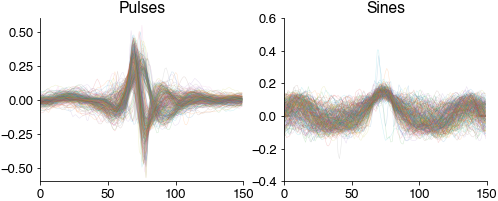

In [3]:
win_hw = 100
pulseshapes = deepss_unsupervised.event_utils.get_shapes(pulsetimes + win_hw, recording, win_hw)
pulseshapes = np.apply_along_axis(deepss_unsupervised.event_utils.normalize, axis=-1, arr=pulseshapes.T).T
pulseshapes = pulseshapes[25:-25]

sineshapes = deepss_unsupervised.event_utils.get_shapes(sinetimes + 2*win_hw, recording, win_hw)
sineshapes = np.apply_along_axis(deepss_unsupervised.event_utils.normalize, axis=-1, arr=sineshapes.T).T
sineshapes = sineshapes[25:-25]

good_shapes = np.sum((sineshapes==0).astype(np.float), axis=0)<10
sineshapes = sineshapes[:, good_shapes]

allshapes = np.concatenate((pulseshapes, sineshapes), axis=1)
print('Pulses:', pulseshapes.shape, 'sines:', sineshapes.shape, 'all:', allshapes.shape)
good_shapes = np.sum((sineshapes==0).astype(np.float), axis=0)<10
sineshapes = sineshapes[:, good_shapes]

plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.plot(pulseshapes, linewidth=0.5, alpha=0.2)
plt.title('Pulses')

plt.subplot(122)
plt.plot(sineshapes, linewidth=0.5, alpha=0.2)
plt.title('Sines')
plt.show()

Embed all pulse ans sine waveforms into a two-dimensional spaces using the umap method and cluster the resulting points clouds using density-based clustering (hdbscan).

In [4]:
out = umap.UMAP(min_dist=0.5).fit_transform(allshapes.T)
hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=20).fit_predict(out)

This results in three distinct point clouds (each point corresponds to a waveform in the UMAP space). The three cluster centroids contain a slow sustained, a broad symmetrical, and a short asymmetrical waveform.

<ipython-input-5-3f107d78f403>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-5-3f107d78f403>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(222)
<ipython-input-5-3f107d78f403>:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned. 

<ipython-input-5-3f107d78f403>:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(224)


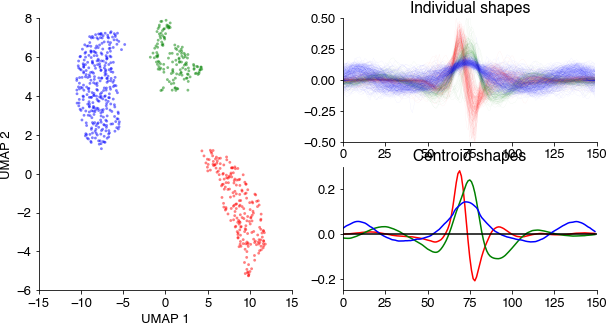

In [5]:
cols = 'rgb'

plt.figure(figsize=(10, 5))
for label in np.unique(hdbscan_labels):
    if label>=0:
        this = hdbscan_labels==label
        
        plt.subplot(121)
        plt.scatter(out[this,0], out[this,1], c=cols[label], s=8, alpha=0.5, edgecolor='none')
        plt.xlabel('UMAP 1')
        plt.ylabel('UMAP 2')
        
        plt.subplot(222)
        plt.plot(allshapes[:, this], c=cols[label], alpha=0.2, linewidth=0.1)
        plt.ylim(-0.5, 0.5)
        plt.title('Individual shapes')
        
        plt.subplot(224)
        plt.plot(np.mean(allshapes[:, this], axis=1), c=cols[label])
        plt.ylim(-0.25, 0.3)
        plt.title('Centroid shapes')
        
plt.axhline(0, c='k')
